In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
import time
import scipy.io as io

import skimage.measure
from keras.initializers import RandomNormal
from keras.callbacks import ModelCheckpoint
from keras.models import *
from keras.layers import *
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.models import model_from_json
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

In [ ]:
import numpy as np
import tensorflow as tf
import random

np.random.seed(16)
tf.random.set_seed(16)
random.seed(16)


In [ ]:
mall_gt = io.loadmat(".../heads-position/mall_gt.mat")
mall_head_pos = mall_gt['frame'][0]

# Split in Train - Val - Test

In [ ]:
#path_frames = '.../frames'
#path_density = '.../density_maps'

path_frames = '.../frames224'
path_density = '.../density224'

img_names = sorted([file for file in os.listdir(path=path_frames) if file.endswith('.jpg')])
den_names = sorted([file for file in os.listdir(path=path_density)])

random_state = 16

# Train_val - test split:
test_proportion = 0.2
Train_val_frames_names, Test_frames_names = train_test_split(img_names, test_size=test_proportion, random_state=random_state)
Train_val_density_names, Test_density_names = train_test_split(den_names, test_size=test_proportion, random_state=random_state)


val_proportion= 0.2

Train_frames_names, Val_frames_names = train_test_split(Train_val_frames_names, test_size=test_proportion, random_state=random_state)
Train_density_names, Val_density_names = train_test_split(Train_val_density_names, test_size=test_proportion, random_state=random_state)



# Save into array Train Images, Ground Truth and Labels

In [ ]:
Train_imgs = []
Train_density = []
Train_labels = []

i=0

for img_name, den_name in zip(sorted(os.listdir(path = path_frames)), sorted(os.listdir(path = path_density))):
    i=i+1

    if img_name in Train_frames_names:


        img = preprocess_input(cv2.cvtColor(cv2.imread(path_frames + img_name), cv2.COLOR_BGR2RGB))
        Train_imgs.append(img)

        img = np.load(path_density + den_name)
        Train_density.append(img)

        Train_labels.append(len(mall_head_pos[i-1][0][0][0]))


Train_imgs = np.asarray(Train_imgs)
Train_density = np.asarray(Train_density)

# Save into array Validation Images, Ground Truth and Labels

In [ ]:
Val_imgs = []
Val_density = []
Val_labels = []

i=0

for img_name, den_name in zip(sorted(os.listdir(path = path_frames)), sorted(os.listdir(path = path_density))):
    i=i+1

    if img_name in Val_frames_names:


        img = preprocess_input(cv2.cvtColor(cv2.imread(path_frames + img_name), cv2.COLOR_BGR2RGB))
        Val_imgs.append(img)

        img = np.load(path_density + den_name)
        Val_density.append(img)

        Val_labels.append(len(mall_head_pos[i-1][0][0][0]))


Val_imgs = np.asarray(Val_imgs)
Val_density = np.asarray(Val_density)

# Save into array Test Images, Ground Truth and Labels

In [ ]:
Test_imgs = []
Test_density = []
Test_labels = []

i=0

for img_name, den_name in zip(sorted(os.listdir(path = path_frames)), sorted(os.listdir(path = path_density))):
    i=i+1

    if img_name in Test_frames_names:


        img = preprocess_input(cv2.cvtColor(cv2.imread(path_frames + img_name), cv2.COLOR_BGR2RGB))
        Test_imgs.append(img)

        img = np.load(path_density + den_name)
        Test_density.append(img)

        Test_labels.append(len(mall_head_pos[i-1][0][0][0]))


Test_imgs = np.asarray(Test_imgs)
Test_density = np.asarray(Test_density)

# Model Definition

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, Input
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.applications import VGG16
import numpy as np
import os

weights_path =".../vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
#weights_path ='/kaggle/working/checkpoints/checkpoint.weights.h5'

def build_CSRnet(input_shape):
    VGG_19 = VGG19(weights=weights_path, include_top=False, input_shape=input_shape)

    VGG_19 = Model(inputs=VGG_19.input, outputs=VGG_19.get_layer('block4_conv4').output)

    Map_estimator_net = Sequential([
        Conv2D(512, (3, 3), dilation_rate=2, padding='same', kernel_initializer=RandomNormal(stddev=0.01)),
        LeakyReLU(negative_slope=0.01),
        Conv2D(512, (3, 3), dilation_rate=2, padding='same', kernel_initializer=RandomNormal(stddev=0.01)),
        LeakyReLU(negative_slope=0.01),
        Conv2D(512, (3, 3), dilation_rate=2, padding='same', kernel_initializer=RandomNormal(stddev=0.01)),
        LeakyReLU(negative_slope=0.01),
        Conv2D(256, (3, 3), dilation_rate=2, padding='same', kernel_initializer=RandomNormal(stddev=0.01)),
        LeakyReLU(negative_slope=0.01),
        Conv2D(128, (3, 3), dilation_rate=2, padding='same', kernel_initializer=RandomNormal(stddev=0.01)),
        LeakyReLU(negative_slope=0.01),
        Conv2D(64, (3, 3), dilation_rate=2, padding='same', kernel_initializer=RandomNormal(stddev=0.01)),
        LeakyReLU(negative_slope=0.01),
        Conv2D(1, (1, 1), dilation_rate=1, padding='same', kernel_initializer=RandomNormal(stddev=0.01)),
        LeakyReLU(negative_slope=0.01)
    ])(VGG_19.output)

    CSRnet = Model(inputs=VGG_19.input, outputs=Map_estimator_net)
    #CSRnet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, weight_decay =5e-4, momentum=0.90), loss="mae", metrics=["mae"])
    CSRnet.compile(optimizer=Adam(learning_rate=1e-5), loss="mae", metrics=["mae"])

    return CSRnet


# Train and Test functions definition

In [ ]:
import os
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential

def train_CSRnet(CSRnet, Train_imgs, Train_density, checkpoint_filepath):
    if not os.path.exists('./checkpoints'):
        os.makedirs('./checkpoints')

    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_mae',
        mode='min',
        save_best_only=True,
        verbose=1)

    early_stopping_callback = EarlyStopping(
        monitor='val_mae',
        patience=10,
        mode='min',
        verbose=1,
        restore_best_weights=True)

    history = CSRnet.fit(Train_imgs, Train_density,validation_data=(Val_imgs, Val_density),
                         batch_size=1, epochs=100,
                         steps_per_epoch=100,
                         callbacks=[model_checkpoint_callback, early_stopping_callback])

    return history

def test_CSRnet(CSRnet, Test_imgs, Test_labels, file_parameters_path):
    CSRnet.load_weights(file_parameters_path)

    mae_error = 0
    mse_error = 0
    mape_error = 0


    N = len(Test_labels)
    for i, (x, y) in enumerate(zip(Test_imgs, Test_labels)):

        print(i)


        mae_error += np.abs(np.sum(CSRnet.predict(np.reshape(np.asarray(x),(1, x.shape[0], x.shape[1], x.shape[2])))) - y)
        mse_error += np.square(np.sum(CSRnet.predict(np.reshape(np.asarray(x),(1, x.shape[0], x.shape[1], x.shape[2])))) - y)
        mape_error += np.abs((np.sum(CSRnet.predict(np.reshape(np.asarray(x),(1, x.shape[0], x.shape[1], x.shape[2])))) - y) / y)* 100



    return mae_error/N, np.sqrt(mse_error/N), mape_error/N
checkpoint_filepath = './checkpoints/checkpoint.weights.h5'



#input_shape = (480, 640, 3)
#input_shape = (None, None, 3)
input_shape = (224, 224, 3)
CSRnet = build_CSRnet(input_shape)
CSRnet.summary()

history = train_CSRnet(CSRnet, Train_imgs, Train_density, checkpoint_filepath)

if os.path.isfile(checkpoint_filepath):
    print(f"The best weights have been saved in: {checkpoint_filepath}")
else:
    print(f"The weights were not saved correctly. Check the path: {checkpoint_filepath}")




Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 28, 28, 1)      │     8,628,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,213,377 (73.29 MB)

 Trainable params: 19,213,377 (73.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
  2/100 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0445 - mae: 0.0445  

I0000 00:00:1720624610.232927   21414 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0099 - mae: 0.0099
Epoch 1: val_mae improved from inf to 0.00683, saving model to ./checkpoints/checkpoint.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - loss: 0.0099 - mae: 0.0099 - val_loss: 0.0068 - val_mae: 0.0068
Epoch 2/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0068 - mae: 0.0068
Epoch 2: val_mae improved from 0.00683 to 0.00484, saving model to ./checkpoints/checkpoint.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - loss: 0.0068 - mae: 0.0068 - val_loss: 0.0048 - val_mae: 0.0048
Epoch 3/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0047 - mae: 0.0047
Epoch 3: val_mae improved from 0.00484 to 0.00398, saving model to ./checkpoints/checkpoint.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 0.0047 - mae: 0.0047 - val_loss: 0.0040 - val_mae: 0.0040
Epoch 4/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0040 - mae: 0.0040
Epoch 4: val_mae improved from 0.00398 to 0.00350

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 13: val_mae did not improve from 0.00289
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.0029 - mae: 0.0029 - val_loss: 0.0030 - val_mae: 0.0030
Epoch 14/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0028 - mae: 0.0028
Epoch 14: val_mae improved from 0.00289 to 0.00284, saving model to ./checkpoints/checkpoint.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - loss: 0.0028 - mae: 0.0028 - val_loss: 0.0028 - val_mae: 0.0028
Epoch 15/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0029 - mae: 0.0029
Epoch 15: val_mae improved from 0.00284 to 0.00279, saving model to ./checkpoints/checkpoint.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - loss: 0.0029 - mae: 0.0029 - val_loss: 0.0028 - val_mae: 0.0028
Epoch 16/100
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0029 - mae: 0.0029
Epoch 16: val_mae did not improve from 0.00279
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.0029 - mae: 0.0029 - val_loss: 0.0028 - val_mae: 0.0028
Epoch 17/100


## Test Values

In [ ]:
mae, mse, mape  = test_CSRnet(CSRnet, Test_imgs, Test_labels, checkpoint_filepath)
print(f"Mean Absolute Error: {mae}, Mean Square Error: {mse}, Mean Absolute Percentage Error:{mape}")

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17m

# Print some images and train curve

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


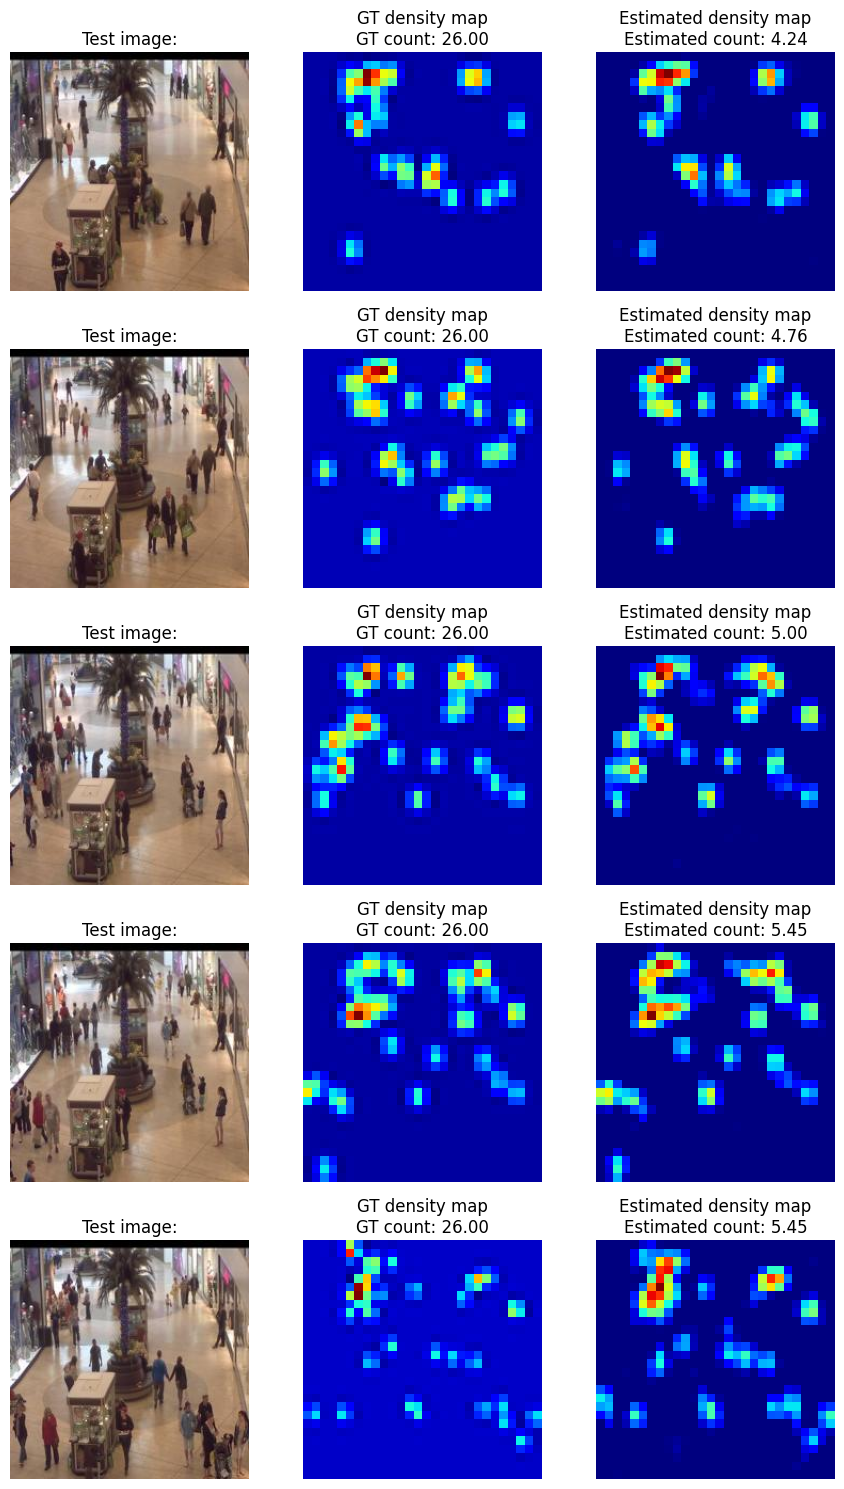

In [ ]:
to_print = 5
plt.figure(figsize=(9, 3 * to_print))

#path_frames = '.../frames/'
path_frames = '.../frames224/'

cont = 0
printed = 0

for img_name in sorted(os.listdir(path_frames)):
    cont += 1

    for i, (img, dens, raw) in enumerate(zip(Test_imgs, Test_density,  sorted(Test_frames_names))):
        if img_name in Test_frames_names:
            if printed == to_print:
                break

            estimated_dens = CSRnet.predict(np.reshape(np.asarray(img), (1, img.shape[0], img.shape[1], img.shape[2])))

            true_number = len(mall_head_pos[cont - 1][0][0][0])
            predicted_number = np.sum(estimated_dens)

            plt.subplot(to_print, 3, printed * 3 + 1)
            plt.axis("off")
            plt.title("Test image:")
            plt.imshow(cv2.cvtColor(cv2.imread(path_frames + raw), cv2.COLOR_BGR2RGB))

            plt.subplot(to_print, 3, printed * 3 + 2)
            plt.axis("off")
            plt.title(f"GT density map\nGT count: {true_number:.2f}")
            plt.imshow(dens, cmap=cm.jet)

            plt.subplot(to_print, 3, printed * 3 + 3)
            plt.axis("off")
            plt.title(f"Estimated density map\nEstimated count: {predicted_number:.2f}")
            plt.imshow(estimated_dens.reshape((estimated_dens.shape[1], estimated_dens.shape[2], 1)), cmap=cm.jet)

            printed += 1

        if printed == to_print:
            break

plt.tight_layout()
plt.show()


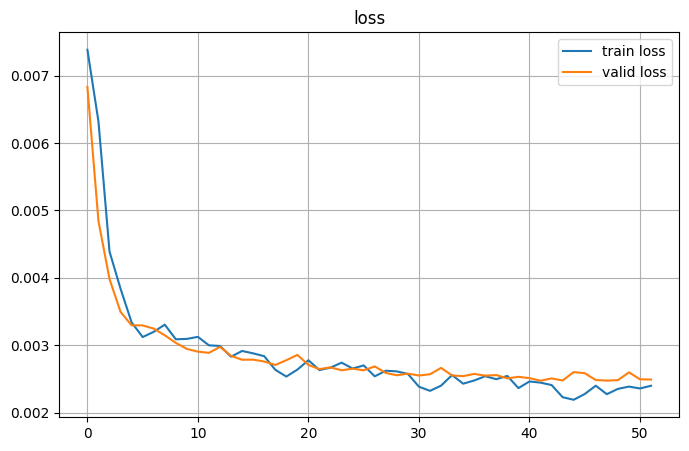

In [ ]:
def plot_learning_curves(history):

    plt.figure(figsize=(8, 5))
    plt.plot(history.epoch,history.history['loss'], label='train loss')
    plt.plot(history.epoch,history.history['val_loss'], label='valid loss')
    plt.legend()
    plt.title('loss')
    plt.grid(True)
    plt.show()
plot_learning_curves(history)